In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
import datetime as dt
from datetime import datetime,timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Flask/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x21683ad3a08>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'longitude': -157.8168,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US'}

# Exploratory Climate Analysis

In [11]:
from sqlalchemy.sql.expression import text

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_day = session.query(func.max(measurement.date).label("max_day")).one()

dt_last_day = dt.datetime.strptime(last_day.max_day,"%Y-%m-%d")

query_date = dt_last_day - dt.timedelta(days=365)
print(query_date.date())

# Perform a query to retrieve the data and precipitation scores
precipition_data = session.query(measurement.date,measurement.prcp).filter(measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precipition_data[:], columns=['Date', 'Precipitation_score'])
df.set_index(df['Date'], inplace=True)
df.head(10)

# Sort the dataframe by date
df_sort = df.sort_index()
df_sort.head(10)

#Hay nulos no se tienen que quitar?
#nulls_array = pd.isnull(df_sort["Precipitation_score"]) 
#df_sort[bool_series]



2016-08-23


,Date,Precipitation_score
Date,,
2016-08-24,2016-08-24,0.08
2016-08-24,2016-08-24,NaN
2016-08-24,2016-08-24,2.15
2016-08-24,2016-08-24,2.28
2016-08-24,2016-08-24,2.15
2016-08-24,2016-08-24,1.45
2016-08-24,2016-08-24,1.22
2016-08-25,2016-08-25,0.08
2016-08-25,2016-08-25,0.00


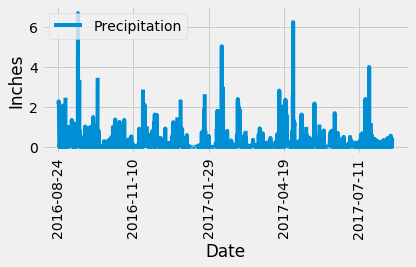

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = df_sort.plot(rot=90)
plt.ylabel("Inches")
plt.xlabel("Date")
ax.legend(["Precipitation"],loc='best')
plt.tight_layout()
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df_sort.describe()


,Precipitation_score
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
station_data = session.query(measurement.station,measurement.id).all()
df_stations = pd.DataFrame(station_data[:], columns=['stations','id'])
stations_count = len(df_stations.stations.unique())

print(f'The number of stations in the data set are: {stations_count}')

The number of stations in the data set are: 9


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_active = df_stations.groupby(['stations']).count().sort_values(by="id",ascending=False)
more_active = station_active.index[0]
more_active

'USC00519281'

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_data_min = session.query(func.min(measurement.tobs)).\
                        filter(measurement.station == more_active).scalar()
print(f'The lowest temperature in {more_active} station is {temp_data_min}')

temp_data_max = session.query(func.max(measurement.tobs)).\
                        filter(measurement.station == more_active).scalar()
print(f'The maximum temperature in {more_active} is {temp_data_max}')

temp_data_avg = session.query(func.avg(measurement.tobs)).\
                        filter(measurement.station == more_active).scalar()
print(f'The average temperature in {more_active} is {round(temp_data_avg,2)}')



The lowest temperature in USC00519281 station is 54.0
The maximum temperature in USC00519281 is 85.0
The average temperature in USC00519281 is 71.66


Station with the highest temperature USC00519281


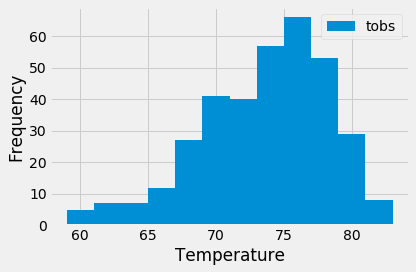

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(measurement.station, measurement.tobs).all()
df_temp = pd.DataFrame(temp_data[:], columns=['station','temp'])
df_temp_more_obs = df_temp.groupby(by='station').count().sort_values(by='temp',ascending=False)
print(f'Station with the highest temperature {df_temp_more_obs.index[0]}')

temp_data = session.query(measurement.station, measurement.tobs,measurement.date).filter(measurement.station == df_temp_more_obs.index[0]).all()
df_temp_USC00519281 = pd.DataFrame(temp_data[:], columns=['station','temp','date'])
df_temp_USC00519281.dtypes
df_temp_USC00519281['Date_type']= pd.to_datetime(df_temp_USC00519281['date']) 

df_temp_12months = df_temp_USC00519281.loc[df_temp_USC00519281['Date_type']>=query_date]

hist = df_temp_12months['temp'].hist(bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.legend(["tobs"],loc='best')
plt.tight_layout()
plt.show()


## Bonus Challenge Assignment

## Temperature Analysis I

In [19]:
# Temperatures in june query 

jun_readings = session.query(measurement.tobs).\
        filter(func.strftime("%m-%d", measurement.date) >= '06-01').\
        filter(func.strftime("%m-%d", measurement.date) <= '06-30').all()
   
jun_readings_df = pd.DataFrame(jun_readings)
print(f'Temperature mean in june: {jun_readings_df.tobs.mean()}')

Temperature mean in june: 74.94411764705882


In [20]:
# Temperatures in Dec query 

dec_readings = session.query(measurement.tobs).\
        filter(func.strftime("%m-%d", measurement.date) >= '12-01').\
        filter(func.strftime("%m-%d", measurement.date) <= '12-31').all()

dec_readings_df = pd.DataFrame(dec_readings)  
print(f'Temperature mean in june: {dec_readings_df.tobs.mean()}')

Temperature mean in june: 71.04152933421226


In [21]:
# t-test between the two months

stats.ttest_ind(jun_readings_df, dec_readings_df)

Ttest_indResult(statistic=array([31.60372399]), pvalue=array([3.9025129e-191]))

## Temperature Analysis II

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_results = calc_temps("2017-01-01", "2018-01-01")

for record in calc_results:
    (min_value, avg_value, max_value) = record
    
print(f'tmin: {min_value}, tavg: {round(avg_value,2)}, and tmax: {max_value}')

tmin: 58.0, tavg: 74.14, and tmax: 87.0


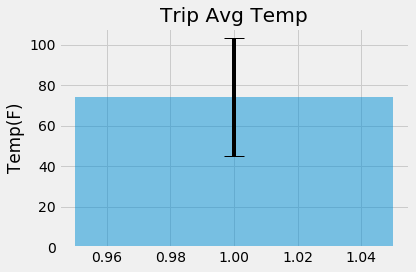

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y_value = round(avg_value,2)
y_err = max_value-min_value
x_pos = 1

fig, ax = plt.subplots()
ax.bar(x_pos,y_value, width=.1,yerr=y_err, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.title("Trip Avg Temp")
ax.set_ylabel('Temp(F)')
plt.tight_layout()
plt.show()


In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [func.sum(measurement.prcp), measurement.station,station.station, station.name, station.latitude, station.longitude, station.elevation]
rainfall_station = session.query(*sel).filter(measurement.date >= "2017-01-01").filter(measurement.date <= "2018-01-01").\
                    group_by(measurement.station).filter(measurement.station == station.station).limit(10).all()

rainfall_list = []
for record in rainfall_station:
    rainfall_dict={}
    (total_rain, meas_station, stat_station, stat_name,stat_lat,stat_lon,stat_elev) = record
    rainfall_dict['meas_station'] = meas_station
    rainfall_dict['total_rain'] = total_rain
    rainfall_dict['stat_name'] = stat_name
    rainfall_dict['stat_lat'] = stat_lat
    rainfall_dict['stat_lon'] = stat_lon
    rainfall_dict['stat_elev'] = stat_elev
    rainfall_list.append(rainfall_dict)

rainfall_df = pd.DataFrame(rainfall_list)
rainfall_df.sort_values(by='total_rain',ascending=False)


,meas_station,total_rain,stat_name,stat_lat,stat_lon,stat_elev
2,USC00516128,68.78,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
4,USC00519281,43.66,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
0,USC00513117,34.62,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
6,USC00519523,27.32,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
1,USC00514830,21.80,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00519397,10.66,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
3,USC00517948,3.39,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2018-01-01'
end_date = '2018-01-07'

# Use the start and end date to create a range of dates
datelist = pd.date_range(start_date,end_date).tolist()

# Stip off the year and save a list of %m-%d strings
date_list = []
for date in datelist:
    date_add = date.strftime("%m-%d")
    date_list.append(date_add)


# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals_list = []
for date in date_list:
    daily_normals_record = daily_normals(date)
    for record in daily_normals_record:
        date_list_dict={}
        (min_tobs, avg_tobs, max_tobs) = record
        date_list_dict['min_tobs'] = min_tobs
        date_list_dict['avg_tobs'] = round(avg_tobs,2)
        date_list_dict['max_tobs'] = max_tobs
        daily_normals_list.append(date_list_dict)
    
daily_normals_list


[{'min_tobs': 62.0, 'avg_tobs': 69.15, 'max_tobs': 77.0},
 {'min_tobs': 60.0, 'avg_tobs': 69.4, 'max_tobs': 77.0},
 {'min_tobs': 62.0, 'avg_tobs': 68.91, 'max_tobs': 77.0},
 {'min_tobs': 58.0, 'avg_tobs': 70.0, 'max_tobs': 76.0},
 {'min_tobs': 56.0, 'avg_tobs': 67.96, 'max_tobs': 76.0},
 {'min_tobs': 61.0, 'avg_tobs': 68.96, 'max_tobs': 76.0},
 {'min_tobs': 57.0, 'avg_tobs': 68.54, 'max_tobs': 76.0}]

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
date_list = []
for date in datelist:
    date_add = date.strftime("%Y-%m-%d")
    date_list.append(date_add)
    
daily_normals_df = pd.DataFrame(daily_normals_list,index=date_list)

daily_normals_df

,min_tobs,avg_tobs,max_tobs
2018-01-01,62.0,69.15,77.0
2018-01-02,60.0,69.40,77.0
2018-01-03,62.0,68.91,77.0
2018-01-04,58.0,70.00,76.0
2018-01-05,56.0,67.96,76.0
2018-01-06,61.0,68.96,76.0
2018-01-07,57.0,68.54,76.0


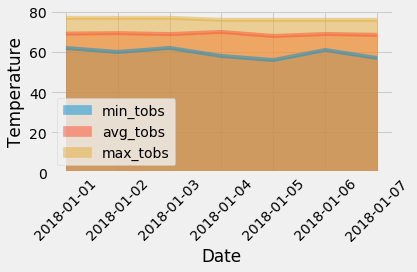

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
ax = daily_normals_df.plot.area(stacked=False,rot=45)
plt.ylabel("Temperature")
plt.xlabel("Date")
plt.tight_layout()
plt.show()
#session.close()